# Task 4: Multi-product Highly Non-Stationary Pricing

Notebook with:
- Multi-product highly non-stationary environment (correlated valuations)
- Primal–Dual agent with one Hedge learner per product (fixed price grid)
- Clairvoyant baseline (best fixed price vector in hindsight, chronological acceptance until inventory P)
- Regret computation and plots aggregated over multiple simulations
- NB: the inventory P is shared among the different types of product


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import multivariate_normal
import itertools
plt.rcParams['figure.figsize'] = (16, 9)
np.random.seed(42)


## Environment Setup

In [2]:
class HighlyNonStatMultiProductPricingEnvironment:
    """
    Multi-product highly non-stationary environment for dynamic pricing with inventory constraint.

    This environment simulates a multi-product pricing scenario where:
    - Each product has its own customer valuation distribution
    - These distributions change every round (changing mean and std for non-stationarity)
    - Customers have different preferences for different products
    - Each round represents one customer interaction
    - The customer can purchase multiple products or none at all
    """

    def __init__(self, valuation_dists, prices_grid, demand_noise_std=0.0):
        """
        Initialize the multi-product pricing environment.

        Args:
            valuation_dists: List of mvn distributions for each round
            prices_grid : Fixed grid of possible discretized prices (dimensions: n_products x K)
            demand_noise_std: Std of optional gaussian noise on valuations
        """
        self.valuation_dists = valuation_dists
        self.T = len(valuation_dists)
        self.n_products = prices_grid.shape[0]
        self.prices_grid = prices_grid
        self.current_round = 0
        self.noise_std = demand_noise_std

    def simulate_round(self, price_vector, offered_mask=None):
        """
        Simulate one customer interaction for a given product subset and prices.

        Args:
            price_vector: Array of prices for each product
            offered_mask: List of product indices being offered (if None, all products are offered)

        Returns:
            tuple: (purchases, total_revenue, per_product_revenue, valuations) where:
                - purchases: List of products actually purchased
                - total_revenue: Sum of revenues from purchased products
                - per_product_revenue: Array of revenue for each product
                - valuations: Exact valuations for each product (array of length n_products) at current round (one vector for each round)
        """
        if offered_mask is None:
            offered_mask = np.ones(self.n_products, dtype=bool)
        
        idx = min(self.current_round, self.T - 1)
        mvn = self.valuation_dists[idx]
        valuations = np.atleast_1d(mvn.rvs())
        if self.noise_std > 0:
            valuations = valuations + np.random.normal(0.0, self.noise_std, size=self.n_products)
        
        purchases = (offered_mask & (valuations >= price_vector)).astype(int)
        per_product_revenue = purchases * price_vector
        total_revenue = float(per_product_revenue.sum())
        
        self.current_round += 1

        return purchases, total_revenue, per_product_revenue, valuations


## Agents Definition

### Hedge Regret Minimizer

In [3]:
class HedgeAgent1D:
    """
    Hedge algorithm agent for 1-dimensional expert problem.

    This agent implements the multiplicative weights strategy where:
    1. K arms are available, each with an initially equal probability
    2. Action selection is probabilistic, weighted by the current arm weights
    3. Rewards are clipped to [0, 1]
    4. Losses are computed as (1 - reward) for weight updates
    5. Weights are updated multiplicatively: w_i ← w_i * exp(-η * loss_i)
    6. The learning rate (η) controls how quickly the agent adapts to losses
    """

    def __init__(self, K, learning_rate):
        """
        Initialize the HedgeAgent1D.

        Args:
            K (int): Number of available arms, i.e. number of possible prices (assumed equal for each type of product)
            learning_rate (float): Learning rate η for the multiplicative weights update
        """
        self.K = K
        self.lr = learning_rate
        self.weights = np.ones(K, dtype=float)    # Initial equal weights (= 1) for all arms
        self.prob = np.ones(K, dtype=float) / K   # Initial uniform probabilities
        self.last_arm = 0                         # Index of the last pulled arm

    def pull_arm(self):
        """
        Select an arm to pull based on the current weight distribution.

        Returns:
            int: Index of the chosen arm
        """
        self.prob = self.weights / self.weights.sum()      # Normalize weights to probabilities
        self.last_arm = np.random.choice(np.arange(self.K), p=self.prob)
        
        return self.last_arm
    
    def update(self, reward_vector_01):
        """
        Update the arm weights based on observed rewards (full-feedback).

        Args:
            reward_vector_01 (array-like): Vector of observed rewards for all arms
                                           each in the range [0, 1]
                                           1 = full reward, 0 = no reward
        """
        loss = 1.0 - np.clip(reward_vector_01, 0.0, 1.0)   # Compute loss as 1 - reward (clipped to [0, 1])
        self.weights *= np.exp(-self.lr * loss)            # Multiplicative weights update rule


### Primal-Dual Agent

In [4]:
class MultiProductPrimalDualAgent:
    """
    Multi-product pricing agent using a primal-dual approach with per-product Hedge learners.

    This agent is designed for an online pricing problem with multiple products and an overall
    inventory constraint. It combines:
    1. A primal-dual update for the dual variable λ controlling the inventory constraint
    2. A separate Hedge algorithm learner for each product to choose prices (arms) from a discrete grid
    3. Normalized rewards based on per-product revenue adjusted for inventory consumption
    4. Learning rate for Hedge learners set as the square root of log(K)/T (according to the theory)
    5. History tracking for analysis (prices, purchases, revenue, inventory, λ)

    Attributes:
        prices_grid (ndarray): Matrix (n_products x K) of discrete price options for each product
        n_products (int): Number of products
        K (int): Number of price options (arms) per product
        T (int): Time horizon
        P (int): Total inventory across all products
        eta (float): Learning rate for λ updates (dual variable)
        learners (list): One HedgeAgent1D instance per product
        rho (float): Average inventory allowed per round (P/T)
        lmbd (float): Dual variable for inventory constraint.
        remaining_inventory (int): Inventory remaining at current step
        history (dict): Records time series of key variables
        cum_reward_per_arm (ndarray): Cumulative unnormalized reward per arm per product
        max_price (float): Maximum price in the price grid
    """

    def __init__(self, prices_grid, T, P, eta, lambda_init=None):
        """
        Initialize the primal-dual multi-product pricing agent.

        Args:
            prices_grid (ndarray): Array of shape (n_products, K) containing price options for each product
            T (int): Time horizon (number of rounds)
            P (int): Total inventory available across all products
            eta (float): Learning rate for updating the dual variable λ
            lambda_init (float, optional): Initial λ value; defaults to 0.5 / rho if None
        """
        self.prices_grid = prices_grid
        self.n_products, self.K = prices_grid.shape
        self.T = T
        self.P = P
        self.eta = float(eta)
        lr = np.sqrt(max(1e-12, np.log(self.K)) / max(1, T))
        self.learners = [HedgeAgent1D(self.K, lr) for _ in range(self.n_products)]
        self.rho = self.P / float(self.T)
        self.lmbd = (0.5 / max(self.rho, 1e-9)) if (lambda_init is None) else float(lambda_init)
        self.remaining_inventory = int(self.P)
        self.history = {"prices": [], "purchases": [], "revenue": [], "inventory": [], "lambda": []}
        self.cum_reward_per_arm = np.zeros((self.n_products, self.K), dtype=float)
        self.max_price = float(self.prices_grid.max())

    def bid(self):
        """
        Select prices for all products based on the current Hedge learners.

        Returns:
            ndarray: Array of length n_products with the chosen prices for each product
        """
        arms = np.array([h.pull_arm() for h in self.learners], dtype=int)
        prices = self.prices_grid[np.arange(self.n_products), arms]
        self.last_arms = arms
        self.last_prices = prices
        
        return prices
    
    def update(self, purchases, per_product_revenue):
        """
        Update Hedge learners and dual variable λ after observing the results of the last bid.

        Args:
            purchases (ndarray): Number of units sold per product in the last round
            per_product_revenue (ndarray): Revenue per product in the last round
        """
        rho_i = self.rho / float(self.n_products)
        L_i = per_product_revenue - self.lmbd * (purchases - rho_i)

        # Normalization bounds for reward scaling
        L_min = -self.lmbd
        L_max = self.max_price + self.lmbd * rho_i
        denom = max(1e-9, (L_max - L_min))

        # Scale to [0, 1] for Hedge update
        reward_01 = np.clip((L_i - L_min) / denom, 0.0, 1.0)

        # Update each Hedge learner
        for i in range(self.n_products):
            r_vec = np.zeros(self.K)
            r_vec[self.last_arms[i]] = reward_01[i]
            self.learners[i].update(r_vec)
            self.cum_reward_per_arm[i] += r_vec * (L_max - L_min) + L_min

        # Dual update for λ
        total_c = float(purchases.sum())
        self.lmbd = np.clip(self.lmbd - self.eta * (self.rho - total_c), a_min=0.0, a_max=1.0 / max(self.rho, 1e-9))
        
        # Update remaining inventory and history
        self.remaining_inventory = max(0, self.remaining_inventory - int(total_c))
        self.history["prices"].append(self.last_prices.copy())
        self.history["purchases"].append(purchases.copy())
        self.history["revenue"].append(float(per_product_revenue.sum()))
        self.history["inventory"].append(int(self.remaining_inventory))
        self.history["lambda"].append(float(self.lmbd))


## Time-Varying Valuations

In [5]:
def build_time_varying_mvn_list(T, n_products, base_corr=0.5, mean_range=(0.2, 1.0), std_range=(0.05, 0.25), seed=0):
    """
    Build a sequence of time-varying multivariate normal (MVN) distributions
    representing correlated valuations for multiple products.

    The generated environment is highly non-stationary:
    - At each time step `t`, a new MVN is defined over all products.
    - Product means evolve over time with autocorrelation and random shocks.
    - Standard deviations vary per product and per time step.
    - A fixed correlation structure (base_corr) is applied across products,
      adjusted to ensure the covariance matrix is positive semi-definite (PSD).

    Args:
        T (int): Number of time steps (rounds) to simulate
        n_products (int): Number of products (dimensions in MVN)
        base_corr (float, optional): Base correlation between products, in [-1, 1]
                                     Defaults to 0.5
        mean_range (tuple of float, optional): Minimum and maximum mean values
                                               for product valuations. Defaults to (0.2, 1.0)
        std_range (tuple of float, optional): Minimum and maximum standard deviations
                                              for product valuations. Defaults to (0.05, 0.25)
        seed (int, optional): Random seed for reproducibility. Defaults to 0

    Returns:
        list of scipy.stats._multivariate.multivariate_normal_frozen:
            A list of length T, where each element is a frozen MVN distribution
            (mean vector and covariance matrix) for that time step

    Notes:
        - Means evolve as: mean_t = 0.4 * mean_{t-1} + 0.6 * (mean_t + shock_t),
          clipped to `mean_range`
        - Shocks are Gaussian noise with mean 0 and std 0.5
        - Covariance matrices are built as D * R * D, where:
            - D = diagonal matrix of stds for that time step
            - R = constant correlation matrix adjusted if needed for PSD
        - `allow_singular=True` is used to handle near-singular covariances
    """
    rng = np.random.default_rng(seed)

    # Build base correlation matrix
    R = np.full((n_products, n_products), base_corr, dtype=float)
    np.fill_diagonal(R, 1.0)

    # Ensure positive semi-definiteness
    eigvals = np.linalg.eigvalsh(R)
    if eigvals.min() < 1e-6:
        alpha = 0.9
        R = alpha * R + (1 - alpha) * np.eye(n_products)

    # Initialize evolving means
    means = rng.uniform(mean_range[0], mean_range[1], size=(T, n_products))
    shocks = rng.normal(0.0, 0.5, size=(T, n_products))
    for t in range(1, T):
        means[t] = np.clip(0.4 * means[t-1] + 0.6 * (means[t] + shocks[t]), mean_range[0], mean_range[1])
    
    # Standard deviations per product per time step
    stds = rng.uniform(std_range[0], std_range[1], size=(T, n_products))

    # Build time-varying MVN distributions
    dists = []
    for t in range(T):
        D = np.diag(stds[t])
        cov = D @ R @ D
        dists.append(multivariate_normal(mean=means[t], cov=cov, allow_singular=True))
    
    return dists


## Simulation

In [6]:
def run_one_simulation(T, n_products, prices_per_product, inventory_frac=0.1, eta=0.5, seed=42, lambda_init_mode='mid'):
    """
    Run a single simulation of the highly non-stationary multi-product pricing environment 
    with inventory constraints using the MultiProductPrimalDualAgent.

    Workflow:
    1. Build the price grid for each product (same prices for all products)
    2. Generate time-varying correlated valuation distributions for each round
    3. Set inventory level P based on the inventory fraction of the time horizon
    4. Initialize the environment and the primal-dual pricing agent
    5. For each round:
        a. Agent selects prices via primal-dual Hedge learners
        b. If inventory is available, environment simulates purchases and revenues
        c. Agent updates internal weights and Lagrange multiplier based on rewards and inventory usage
        d. Track valuations, per-round revenue, and cumulative revenue
    6. Return full simulation results, including agent, environment, revenue history, and inventory stats
    """
    price_grid_1d = np.linspace(0.2, 1.8, prices_per_product)
    prices_grid = np.tile(price_grid_1d, (n_products, 1))

    valuation_dists = build_time_varying_mvn_list(T, n_products, seed=seed)

    P = int(T * inventory_frac) # Set total inventory P as a fraction of T

    if lambda_init_mode == 'max':
        lambda_init = 1.0 / max(P / float(T), 1e-9)
    elif lambda_init_mode == 'mid':
        lambda_init = 0.5 / max(P / float(T), 1e-9)
    else:
        lambda_init = None

    env = HighlyNonStatMultiProductPricingEnvironment(valuation_dists, prices_grid)
    agent = MultiProductPrimalDualAgent(prices_grid=prices_grid, T=T, P=P, eta=eta, lambda_init=lambda_init)
    
    total_revenue = 0.0
    first_empty = None
    valuations_history = np.zeros((T, n_products))
    revenue_per_round = np.zeros(T)
    cumulative_revenue = np.zeros(T)

    # Main simulation loop
    for t in range(T):

        # Record the first round when inventory runs out
        if agent.remaining_inventory <= 0 and first_empty is None:
            first_empty = t

        # Agent selects prices via the primal-dual Hedge learners
        price_vec = agent.bid()

        # If inventory is depleted, there are no purchases or revenue
        if agent.remaining_inventory <= 0:
            purchases = np.zeros(n_products, dtype=int)
            per_prod_revenue = np.zeros(n_products, dtype=float)
            valuations = np.zeros(n_products)
        else:
            # Simulate the round: purchases, revenue, and realized valuations
            purchases, _, per_prod_revenue, valuations = env.simulate_round(price_vec)
        
        # Store valuations and update the agent
        valuations_history[t] = valuations
        agent.update(purchases, per_prod_revenue)

        # Update revenue metrics
        total_revenue += float(per_prod_revenue.sum())
        revenue_per_round[t] = float(per_prod_revenue.sum())
        cumulative_revenue[t] = total_revenue
        
    return {
        'agent': agent,
        'env': env,
        'total_revenue': total_revenue,
        'first_inventory_empty': first_empty,
        'P': P,
        'price_grid_1d': price_grid_1d,
        'valuations_history': valuations_history,
        'revenue_per_round': revenue_per_round,
        'cumulative_revenue': cumulative_revenue
    }


In [7]:
def run_simulations(n_sims, T, n_products, prices_per_product, inventory_frac=0.1, eta=0.5, seed=0, lambda_init_mode='mid'):
    """
    Run multiple independent simulations of the multi-product pricing setup.

    Workflow:
    1. For each simulation index:
        a. Call `run_one_simulation` with a different random seed for stochastic variability
    2. Aggregate and return all simulation outputs in a list
    """
    sims = []
    for s in range(n_sims):
        sims.append(run_one_simulation(T=T, n_products=n_products, prices_per_product=prices_per_product,
                                       inventory_frac=inventory_frac, eta=eta, seed=seed + s, lambda_init_mode=lambda_init_mode))
    
    return sims


## Baseline Definition

In [8]:
def compute_clairvoyant_from_valuations(valuations_history, price_grid_1d, P):
    """
    Compute the clairvoyant (offline optimal) pricing strategy given realized valuations.

    This function exhaustively searches over all possible price combinations for the products
    to find the combination that would have maximized revenue, assuming perfect knowledge
    of future valuations.

    Args:
        valuations_history (np.ndarray): T x n_products array of realized valuations for each round.
        price_grid_1d (np.ndarray): Array of available discrete prices for each product.
        P (int): Total inventory available (shared across products).

    Returns:
        best_combo (np.ndarray): The price combination per product that yields maximum revenue.
        best_cum (np.ndarray): Cumulative revenue over time when using this price combination.
    """
    T, n_products = valuations_history.shape
    K = len(price_grid_1d)

    best_total = -1.0
    best_cum = np.zeros(T)
    best_combo = None

    # Iterate over all possible price combinations (cartesian product)
    for combo in itertools.product(range(K), repeat=n_products):
        prices = np.array([price_grid_1d[c] for c in combo])
        purchases = (valuations_history >= prices).astype(int)

        remaining = P       # Track remaining inventory
        cum = np.zeros(T)   # Track cumulative revenue per round
        total = 0.0         # Total revenue

        for t in range(T):
            if remaining <= 0:
                # No inventory left; fill remaining cumulative revenue
                cum[t:] = total
                break

            sold = purchases[t]
            units = int(sold.sum())

            if units == 0:
                # No sales this round
                cum[t] = total
                continue

            # Only sell up to remaining inventory
            to_accept = min(remaining, units)
            accepted_indices = np.where(sold == 1)[0][:to_accept]

            # Compute revenue for accepted sales
            revenue_t = prices[accepted_indices].sum()
            total += revenue_t
            remaining -= to_accept
            cum[t] = total

        # Handle edge case: no sales but still inventory remaining
        if cum[-1] == 0 and remaining > 0:
            cum[-1] = total

        # Update the best combination if this one is better
        if total > best_total:
            best_total = total
            best_cum = cum.copy()
            best_combo = prices.copy()
            
    return best_combo, best_cum


## Results Visualization

In [9]:
def plot_results(sims_results, T):
    """
    Aggregate and visualize the performance of the multi-product pricing agent 
    over multiple simulation runs compared to the clairvoyant benchmark.

    Plots include:
    1. Cumulative revenue (mean ± std) for agent vs clairvoyant
    2. Revenue per round (mean, optionally smoothed with moving average)
    3. Remaining inventory (mean over simulations)
    4. Cumulative regret (mean ± std)
    5. Average regret per round
    6. R_T / T (mean cumulative revenue per round)
    
    Args:
        sims_results: List of simulation results dictionaries, each containing:
                      - 'cumulative_revenue': array of cumulative revenue per round
                      - 'clairvoyant_cum': array of cumulative clairvoyant revenue
                      - 'revenue_per_round': array of per-round revenue
                      - 'agent': the agent object (for inventory history)
        T: Number of rounds per simulation
    """
    n_sims = len(sims_results)

    cum_alg = np.array([res['cumulative_revenue'] for res in sims_results])
    cum_clair = np.array([res['clairvoyant_cum'] for res in sims_results])

    mean_alg = cum_alg.mean(axis=0)
    mean_clair = cum_clair.mean(axis=0)

    std_regret = (cum_clair - cum_alg).std(axis=0)
    mean_regret = mean_clair - mean_alg

    fig, axes = plt.subplots(2, 3, figsize=(20, 12))

    # 1. Cumulative revenue (mean ± std)
    axes[0,0].plot(mean_alg, label='Agent (mean)', linewidth=2)
    axes[0,0].plot(mean_clair, label='Clairvoyant (mean)', linestyle='--', linewidth=2)
    axes[0,0].fill_between(np.arange(T), mean_alg - cum_alg.std(axis=0), mean_alg + cum_alg.std(axis=0), alpha=0.2)
    axes[0,0].set_title('Cumulative Revenue (mean ± std)')
    axes[0,0].legend()

    # 2. Revenue per round (mean, optionally smoothed with moving average)
    rev_per_round = np.array([res['revenue_per_round'] for res in sims_results])
    mean_rev = rev_per_round.mean(axis=0)
    window = min(200, T//20)
    if window>1:
        ma = np.convolve(mean_rev, np.ones(window)/window, mode='valid')
        axes[0,1].plot(range(window-1, T), ma, linewidth=2, label=f'MA-{window}')
    else:
        axes[0,1].plot(mean_rev)
    axes[0,1].set_title('Revenue per Round (mean)')

    # 3. Remaining inventory over time (mean)
    inv = np.array([res['agent'].history['inventory'] for res in sims_results])
    mean_inv = inv.mean(axis=0)
    axes[0,2].plot(mean_inv)
    axes[0,2].set_title('Remaining Inventory (mean)')

    # 4. Cumulative regret (mean ± std)
    axes[1,0].plot(mean_regret, linewidth=2, color='red', label='Mean Cumulative Regret')
    axes[1,0].fill_between(np.arange(T), mean_regret - std_regret, mean_regret + std_regret, color='red', alpha=0.2)
    axes[1,0].set_title('Cumulative Regret (mean ± std)')

    # 5. Average regret per round
    t_vals = np.arange(1, T+1)
    avg_regret = mean_regret / t_vals
    axes[1,1].plot(avg_regret, linewidth=2)
    axes[1,1].axhline(0, linestyle='--', color='gray')
    axes[1,1].set_title('Average Regret per Round (mean)')

    # 6. R_T / T (mean revenue per round)
    R_T_over_T = mean_alg / t_vals
    axes[1,2].plot(R_T_over_T, linewidth=2)
    axes[1,2].set_title('R_T / T (mean)')

    for ax in axes.flatten():
        ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


## Experimental Setup and Execution

Running sim 1/5...
Running sim 2/5...
Running sim 3/5...
Running sim 4/5...
Running sim 5/5...
All sims done.


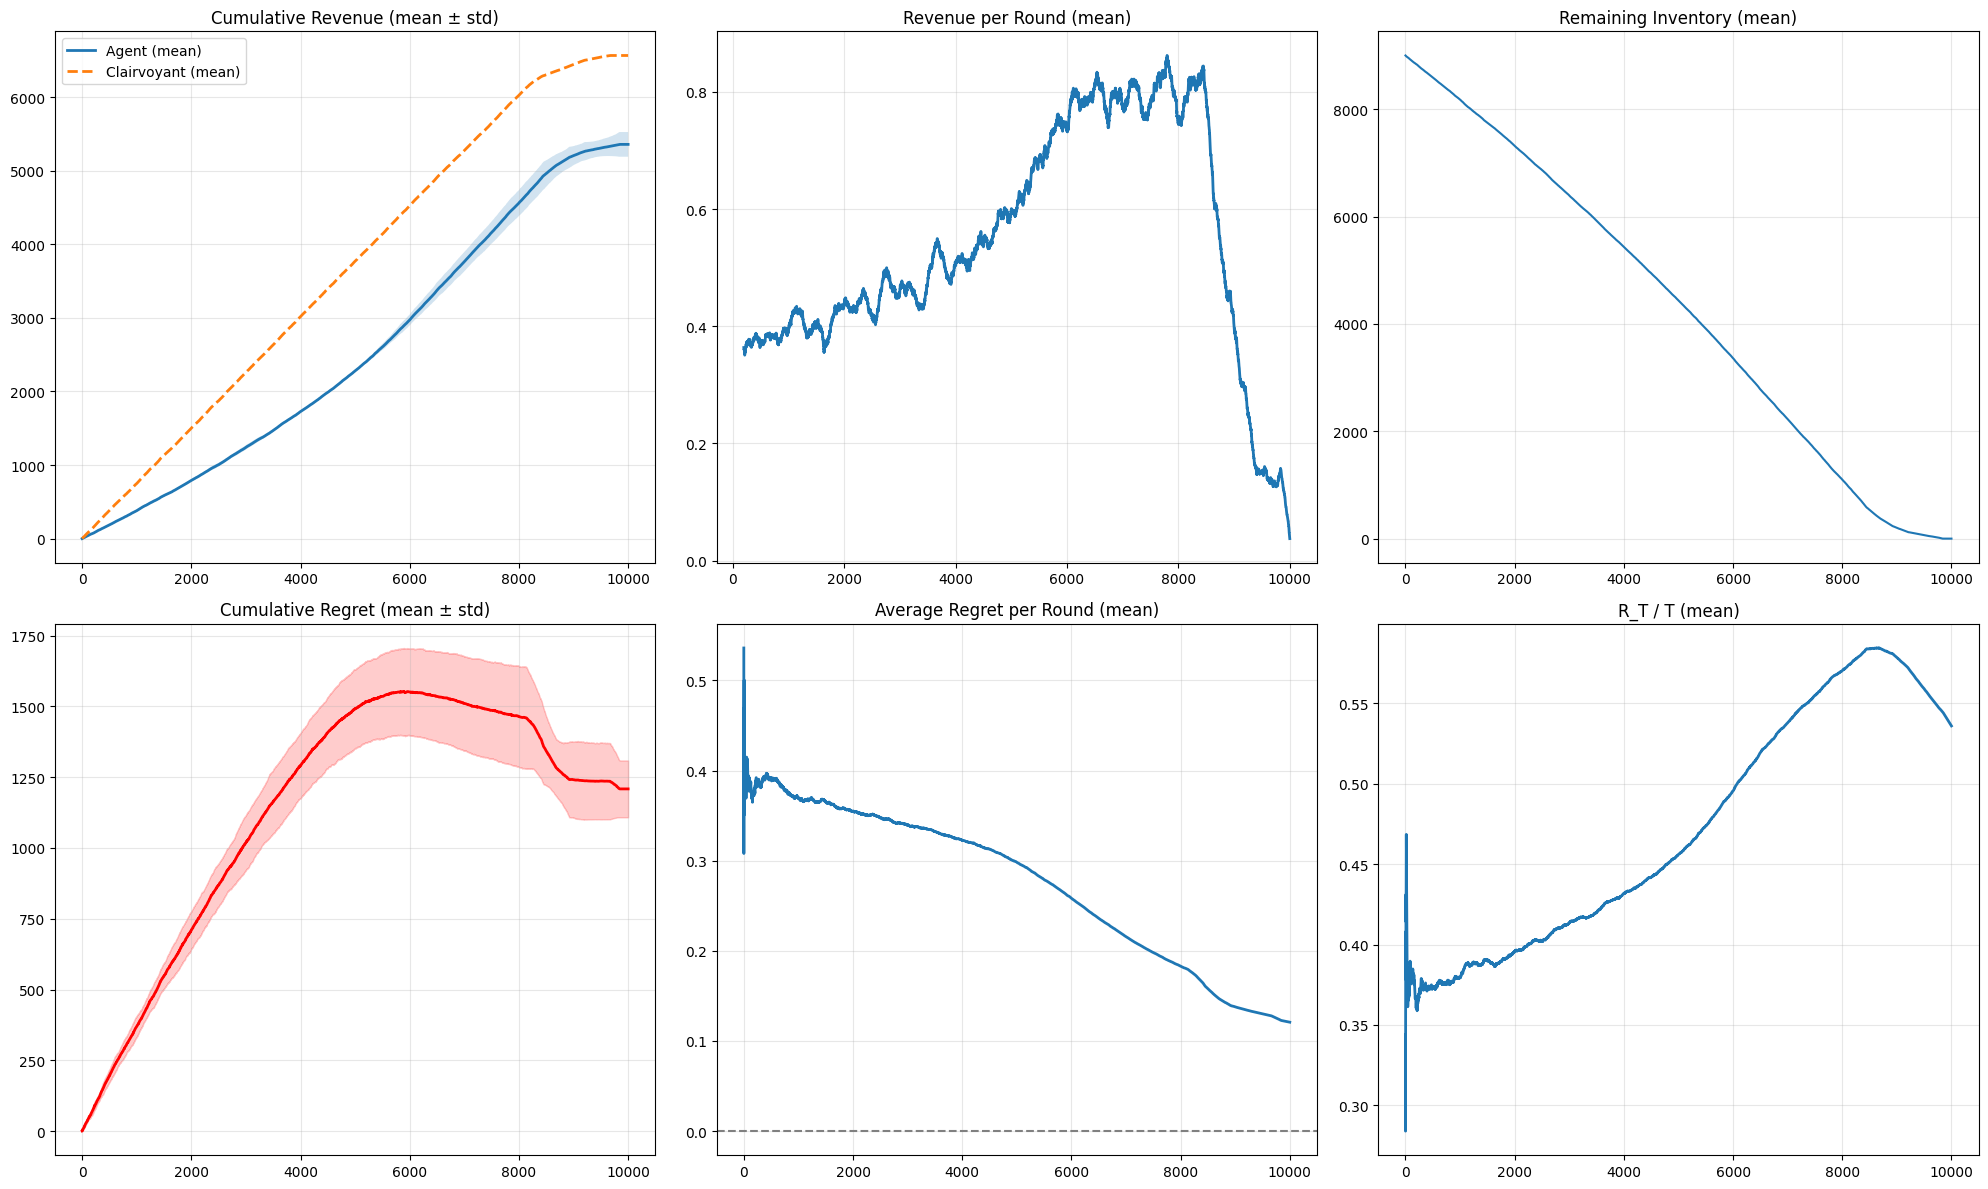

In [10]:
# ----------------------------
# Run a multi-product pricing experiment
# ----------------------------

# Experiment parameters
N_SIMS = 5                # Number of simulation runs
T = 10000                 # Number of rounds per simulation
N_PRODUCTS = 3            # Number of distinct types of products
PRICES_PER_PRODUCT = 11   # Number of discrete prices per product (primo tentativo con 11)
INVENTORY_FRAC = 0.90     # Fraction of total rounds corresponding to inventory (primo tentativo con 0.10)
ETA = 1.0 / np.sqrt(T)    # Learning rate for the dual variable update (agent step-size, primo tentativo con 0.5)
SEED = 202                # Base random seed

sims_results = []

for s in range(N_SIMS):
    print(f'Running sim {s+1}/{N_SIMS}...')

    # Run a single simulation
    res = run_one_simulation(T=T, n_products=N_PRODUCTS, prices_per_product=PRICES_PER_PRODUCT,
                             inventory_frac=INVENTORY_FRAC, eta=ETA, seed=SEED + s, lambda_init_mode='mid')
    
    # Compute the clairvoyant baseline (best fixed price per product)
    best_combo, clair_cum = compute_clairvoyant_from_valuations(res['valuations_history'], res['price_grid_1d'], res['P'])
    
    # Store clairvoyant results in the simulation dictionary
    res['clairvoyant_combo'] = best_combo
    res['clairvoyant_cum'] = clair_cum

    # Append results for this run
    sims_results.append(res)

print('All sims done.')

# Plot aggregated results across simulations
plot_results(sims_results, T)


### Note
- The clairvoyant baseline enumerates all fixed price vectors (K^n) and simulates chronological acceptance up to inventory P, so it is computationally heavy for large K or n, but fine for small settings.
- The regret plotted is **clairvoyant cumulative - agent cumulative**; the shaded band shows ±1 std across simulations.
- Learning rate di Hedge è settata in base alla teoria (radice quadrata di log(K)/T).
- Learning rate del primal-dual agent è settata in base alla teoria (1 fratto radice quadrata di T) ma magari provare altri valori.
- **TO DO**: Aggiustare range dei prezzi e loro discretizzazione. In generale giocare un po' con i valori dei parametri dell'esperimento dato che risultati non sono molto buoni. Specialmente con la frazione dell'inventario (avevo messo 0.1 all'inizio ma inventario si esauriva velocemente nei primi 2k rounds e quindi poi revenue si appiattiva).
